# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation. 

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.


The code for this step is contained in in lines 22 through 42 of the file `help_functions.py`.

- I first read the training data image through mpimg.imread()
- I then convert the images into YCbCr format
- After that, I call the skimage.hog() to extract hog features from each color channel like below code cell

In [4]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  block_norm='L2',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


There is some examples of hog feature for randomly selected car and nocar images


car samples 8792 notcar samples 8968


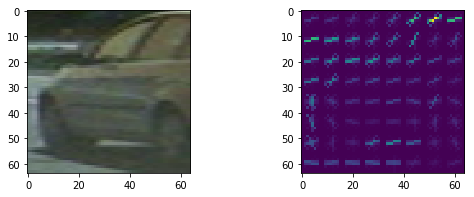

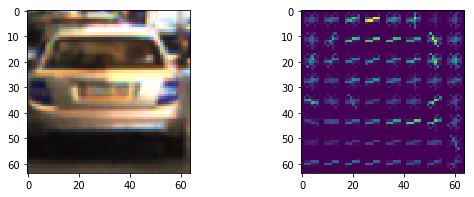

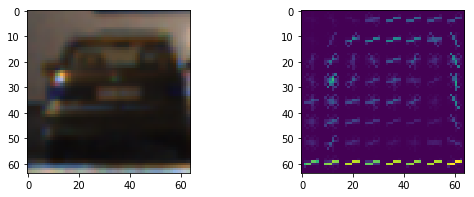

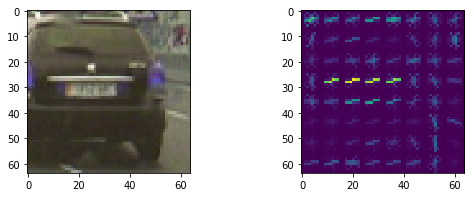

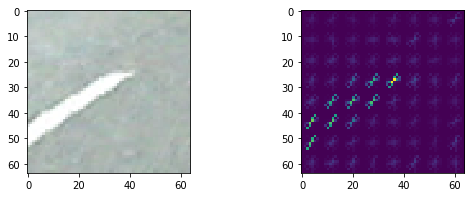

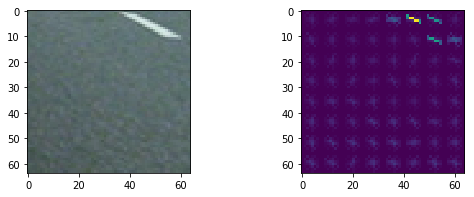

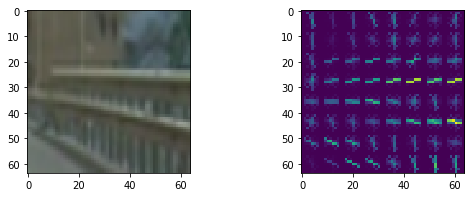

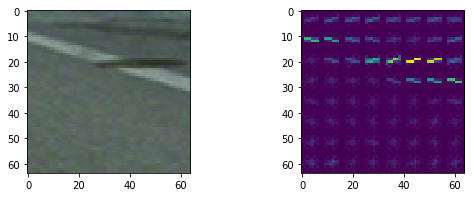

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

car_path  = 'training_data/large/vehicles/'
noncar_path    = 'training_data/large/non-vehicles/'
cars           = [filename for filename in glob.iglob(car_path + '**/*.png', recursive=True)]
notcars        = [filename for filename in glob.iglob(noncar_path + '**/*.png', recursive=True)]
num_of_cars    = len(cars);
num_of_notcars = len(notcars);
sample_size   = 6000
print('car samples ' + str(num_of_cars) + ' notcar samples ' + str(num_of_notcars))
cars          = cars[0:sample_size]
notcars       = notcars[0:sample_size]

def output_hog_features(img_files, orient, pix_per_cell, cell_per_block):
    hog_images = []
    org_images = []
    for img_file in img_files:
        image = cv2.imread(img_file)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
        hog_images.append(hog_image)
        org_images.append(image)
    return org_images, hog_images

car_examples = random.sample(cars, 4)
cars, hog_cars = output_hog_features(car_examples, orient=9, pix_per_cell=8, cell_per_block=2)
notcar_examples = random.sample(notcars, 4)
notcars, hog_notcars = output_hog_features(notcar_examples, orient=9, pix_per_cell=8, cell_per_block=2)

for i in range(4):
    f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
    plot1.imshow(cars[i])
    plot2.imshow(hog_cars[i])
for i in range(4):
    f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
    plot1.imshow(notcars[i])
    plot2.imshow(hog_notcars[i])
plt.show()


#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and found below HOG parameters work best and here is my reason

In [6]:
color_space    = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9  # HOG orientations
pix_per_cell   = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel    = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32) # Spatial binning dimensions
hist_bins      = 32    # Number of histogram bins
spatial_feat   = True # Spatial features on or off
hist_feat      = True # Histogram features on or off
hog_feat       = True # HOG features on or off

- color_space: I first tried with RGB space and have a lot of miss detection and false detection. As the hog feature extraction alogirthm is mostly designed based on grayscale image. Generaelly speaking, RGB does not work best in feature extraction. 
- orient: I tried with 9 and 16 and the classify training results are almost the same. To avoid overcompliate the model. I choose to use 9
- pix_per_cell and cell_per_block: I keep them relatively small to be able to pick subtle features inside images.



I trained a linear SVM using below features:
- hog features for all Y, Cb,Cr channels (`get_hog_features() in help_functions.py`)
- resize the image down to 32x32 and then extract binned color features (`bin_spatial() in help_functions.py`)
- color histogram features of YCbCr images (`color_hist() in help_functions.py`)

For each training image, I stacked all those features into one feature vector. To avoid one of features to dominate the feature vectior, StandardScaler() is used to normalize the feature vector so that they are all zero mean and unit variance . 

There are over 8000 cars and notcar samples. I used ranomly selected 6000 samples and split 70% for training and 30% for testing. 

The code for training the classify is in `train_car_classifier() of classify.py`

In [22]:
print('car samples ' + str(num_of_cars) + ' notcar samples ' + str(num_of_notcars))

car samples 8792 notcar samples 8968


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?


The actual code to implement sliding window search is located in `find_cars()` of `solution.py`

##### scale selection
I use multiple scale to search the the bottom part of the image
scales = [1.15, 1.25, 1.75, 2, 2.25, 2.5, 3]
The sliding window size is fixed at 64 pixels. 64 pixel size is a little bit too small for cars from our project video and instread of changing the sliding window size, I scale down the image which is the same thing as increasing the sliding window size. I found that some cars can only be detected at certain scale.

##### overlap selection
Originally, the sliding window size has 50% of overlapping and I have some false negative. Thefore, I increase to 75% overlap, which is proved to work well.

##### examples

[test1_image]: ./test_images/test1.jpg
[image1]: ./output_images/debug_out/scale_1.15/overlap_75/test1.jpg
[image2]: ./output_images/debug_out/scale_1.15/overlap_50/test1.jpg

Original image: scale 1.15 was used in this example
![alt text][test1_image]
75% overlapping: blue box is the region we have a postive detection 
![alt text][image1]
50% overlapping:
![alt text][image2]





#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Here is some techniques I used to optimize the performance of my classifier:
- use 3 channel pf spatial, color histogram and hog features  
- run multiscale sliding window search to catch vechiles with different size
- create a heap map to add the locations from above step to improve the detection reliablity. I did not apply threshold to the heat map for single image. However, I have a few approaches to reduce false positive and false negative when I am dealing with video.
- label the heatmap to extract the connected graph features
- calculate the best x,y coordinates of minmum size of rectangle which can cover the labels from above step


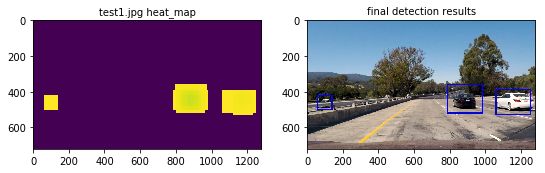

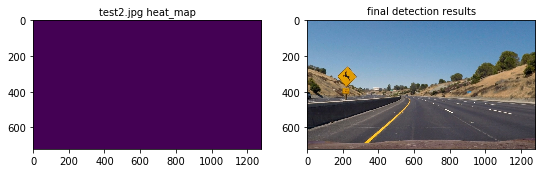

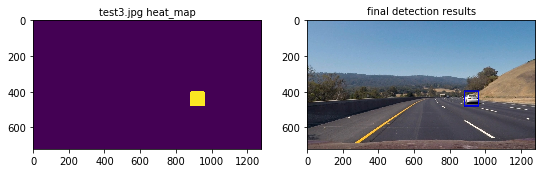

In [43]:
# Examples:
f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
plot1.imshow(plt.imread('output_images/heat_map/test1.jpg'))
plot1.set_title('test1.jpg heat_map', fontsize=10)
plot2.imshow(plt.imread('output_images/test1.jpg'))
plot2.set_title('final detection results', fontsize=10)
plt.show()

f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
plot1.imshow(plt.imread('output_images/heat_map/test2.jpg'))
plot1.set_title('test2.jpg heat_map', fontsize=10)
plot2.imshow(plt.imread('output_images/test2.jpg'))
plot2.set_title('final detection results', fontsize=10)
plt.show()

f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
plot1.imshow(plt.imread('output_images/heat_map/test3.jpg'))
plot1.set_title('test3.jpg heat_map', fontsize=10)
plot2.imshow(plt.imread('output_images/test3.jpg'))
plot2.set_title('final detection results', fontsize=10)
plt.show()

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_out.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

In [46]:
class Vehicle():
    def __init__(self, bbox):
        # was the vehicle detected in the last iteration?
        self.n_detected    = 1
        self.n_nondetected = 0
        self.bbox      = bbox
        self.vechile_w = bbox[1][0] - bbox[0][0]
        self.vechile_h = bbox[1][1] - bbox[0][1]
        self.xpixels   = (bbox[0][0], bbox[1][0])
        self.ypixels   = (bbox[0][1], bbox[1][1])      
class FrameDetectionResult():
    def __init__(self, image, bboxes, name_hint=None):
        # was the vehicle detected in the last iteration?
        self.image         = image  
        self.name_hint     = name_hint
        self.bboxes        = bboxes # raw detection result 
        self.n_bboxes      = len(bboxes)
        self.vechiles_list = None  # vechiles_list based on raw bboxes detection results    

I have created three classes for this project:
- `class Vehicle()`, to store the information about a Vehicle 
- `class FrameDetectionResult()`: to record the detection results of one image
- `class VehiclesDetection()`: the actual object to do the job

- Maintain a global vehicle list. I recorded the detection results of current frame and will only show this vehicle if I have detected for more than 3 times consecutively. This can signifcantly reduce the chance of false detection.
- I also have record the detection results from past 10 frames, if a newly detected frame was detected in the past 10 frames, this vehicle will drawed on the video immediately. This can reduce the chance of false positive.
- On each frame, I will update the Vehicle.n_detected and Vehicle.n_nondetected count depends on whether a vechile from global list detected or not. If the non_detected count grows larger than n_detected count. This vechile will be deleted from global list. 
- I have a special technique `find_best_match()` to match current detected vehicle with global vehicle list. 
- To stablize the vehicle bboxes across frames, I update the global vechile list by using 75% of old bboxs location and 25% of bboxs from detection results of current image
- If the vechile from global vehicle list was not detected, I will shrink its size and update its n_detected and n_nondetected counts. Thefore, if this vechile was not detected for a while, it will eventually be removed from global list. This technique can both reduce the false negative and also prevent a false positive introduced by global vechile list. 




---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

- The most challenging issue I had is false negative on while cars
My classifier is with 0.9914 accuray on test dataset, however when I apply the trained classifier to the project video, I am seeing a lot of false negative for while cars. At first, I suspect the linear SVM was not good enough for this project so I switched to `rbf` kernel of SVC but did see much improvement. My guess is the problem is from training data I used (GTI/KITTI). I explored the training dataset and found that white car samples are quite small. I guess I need have some data augmentation to resolve this issue. 
- Although I already have effort to smooth the vechile location across images but it is still a bit jumpping around.
- Pipelie is too slow. It takes me around 3s to process one frame. This is caused by the multiscale sliding window. I would like to reduce this processing latency later on. 